#### (Meat of the code written by Matthias Loidolt)

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os
import tifffile

import napari
from napari_animation import Animation
from psf import fit_gaussian_3d, plot_psf, compute_fwhm
from models import StackRange

In [3]:
tiff_path = Path('/Users/jamesrowland/Code/napari_goodies/data/2024-07-2_15umBead_25plane_200Frames_00001.tif')

In [4]:
# Assumes stack is of shape (slices, frames, y, x)
stack = tifffile.imread(tiff_path)
forward_stack = np.mean(stack, axis=1)

metadata_fh = open(tiff_path, "rb")
metadata = tifffile.read_scanimage_metadata(metadata_fh)

In [5]:
# Annotate the center of the bead-of-interest (in x y and z)
viewer = napari.Viewer()
viewer.add_image(forward_stack, name="Stacked averaged in Z")

<Image layer 'Stacked averaged in Z' at 0x151e3bd10>

In [7]:
try:
    (z0, y0, x0) = viewer.layers[1].data[0].astype(int)
except IndexError as e:
    raise IndexError("You need to annotate the center of the bead-of-interest with a point in napari") from e


In [8]:
# Enter the approximate extent of the bead in x y and z (x, y = pixels,  z = slice)
x_range = 60
y_range = 60
z_range = 10

xy_maxZ = np.max(forward_stack[z0-z_range:z0+z_range,y0-y_range:y0+y_range,x0-x_range:x0+x_range], axis=0)
xz_maxY = np.max(forward_stack[z0-z_range:z0+z_range,y0-y_range:y0+y_range,x0-x_range:x0+x_range], axis=2)
yz_maxX = np.max(forward_stack[z0-z_range:z0+z_range,y0-y_range:y0+y_range,x0-x_range:x0+x_range], axis=1)

xy_meanZ = np.mean(forward_stack[z0-z_range:z0+z_range,y0-y_range:y0+y_range,x0-x_range:x0+x_range], axis=0)
xz_meanY = np.mean(forward_stack[z0-z_range:z0+z_range,y0-y_range:y0+y_range,x0-x_range:x0+x_range], axis=2)
yz_meanX = np.mean(forward_stack[z0-z_range:z0+z_range,y0-y_range:y0+y_range,x0-x_range:x0+x_range], axis=1)

stack_range = StackRange(x_range, y_range, z_range, xy_maxZ, xz_maxY, yz_maxX, xy_meanZ, xz_meanY, yz_meanX)

In [9]:
zoomedIn_forward_stack_viewer = viewer.add_image(forward_stack[z0-z_range:z0+z_range,y0-y_range:y0+y_range,x0-x_range:x0+x_range], name="zoomed in to bead")

## sliding z
bbox_rects = np.array([[0,1,45], [0,1,55], [0,3,55], [0,3,45]])
bbox_Rects = np.asarray(2*z_range*[bbox_rects])

zzz = np.asarray(4*[np.arange(2*z_range)])
bbox_Rects[:,:,0] = zzz.T

text_parameters = {'text': 'label',
    'size': 15,
    'color': 'red',
    'anchor': 'lower_right'}
properties = {'label': [f'z = {z} μm' for z in np.arange(2*z_range)]}

shapes_layer = viewer.add_shapes(
    bbox_Rects,
    #ndim=2,
    shape_type='polygon',
    face_color=[0,0,0,0],
    edge_color=[0,0,0,0],
    edge_width=1,
    text=text_parameters,
    properties=properties)

In [10]:
popt, pcov = fit_gaussian_3d(forward_stack[z0-z_range:z0+z_range,y0-y_range:y0+y_range,x0-x_range:x0+x_range], [1,1,1])

[np.float64(165.98995906250002), np.float64(14.6850409375), np.float64(60.196278895195356), np.float64(59.54499782338262), np.float64(9.52433594325257), np.float64(741.9851243581375), np.float64(-7.4102951489662985), np.float64(-4.353777160407276), np.float64(733.7832537205951), np.float64(6.027209095686444), np.float64(24.510325973512458)]


In [11]:
fwhm, principle_axis, eigvec = compute_fwhm(popt)

In [12]:
fov_corners_um = metadata[0]['SI.hRoiManager.imagingFovUm']

fov_um = fov_corners_um[2][0] -  fov_corners_um[0][0]
assert fov_um > 0, "Selected the wrong corners"

# Assumes square fov
px_size_um = fov_um / stack.shape[2]

# Check which Z Stack field is correct for yor scope
# This is for Matthias' rig. 
# step_size_um = metadata[0]['SI.hStackManager.stackZStepSize']

# This is for my rig
step_size_um = metadata[0]['SI.hStackManager.actualStackZStepSize']

scalebar_size_um = 1
print(f"FWHM X: {round(fwhm.x * px_size_um, 2)} um\nFWHM Y: {round(fwhm.y * px_size_um, 2)} um\nFWHM Z: {round(fwhm.z * step_size_um, 2)} um")

FWHM X: 10.89 um
FWHM Y: 9.74 um
FWHM Z: 50.27 um


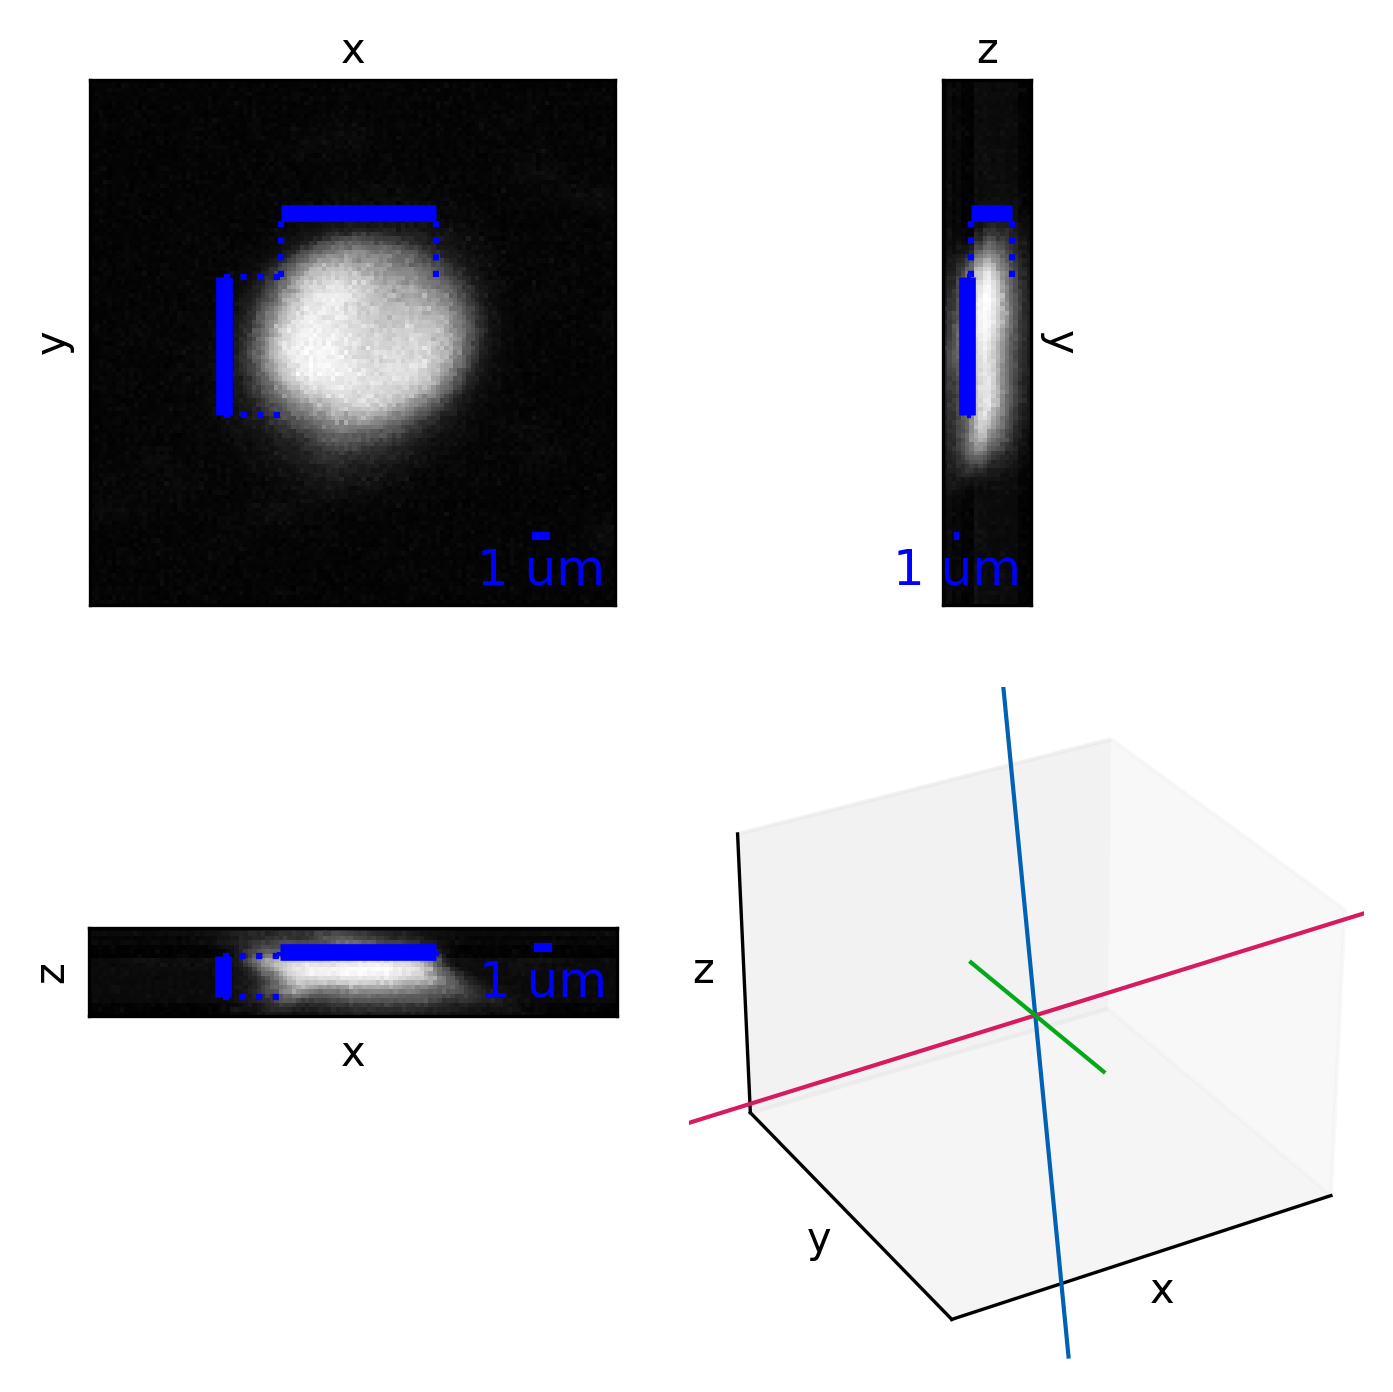

In [13]:
plot_psf(
    popt = popt,
    fwhm = fwhm,
    stack_range = stack_range,
    px_size_um = px_size_um,
    step_size_um = step_size_um,
    principle_axis = principle_axis,
    eigvec = eigvec,
)

#### Code below does not work, requires tidying and multiple beads

NameError: name 'fhwms' is not defined

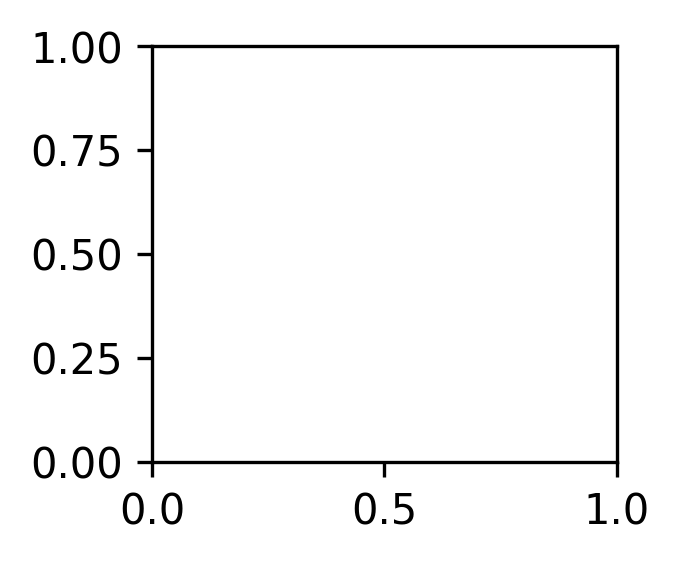

In [16]:
# TODO: This currently requires multiple beads


fig, ax = plt.subplots(figsize=(2,1.8), dpi=300)

bar_names = ['x', 'y', 'z']
bar_positions = np.asarray([1, 2, 3])
num_beads = fhwms.shape[0]

plt.bar(bar_positions[:2], np.mean(fhwms[:,:2], axis=0), yerr=np.std(fhwms[:,:2], axis=0),
             width=0.8, color='blue', error_kw={'elinewidth':3.5})
    
for i_bar, bar_name in enumerate(bar_names[:2]):
    ax.scatter([i_bar+1]*num_beads + np.random.random(num_beads) * 0.1 - 0.3, fhwms[:,i_bar],
               s=15, c='none', edgecolors='black', alpha=1, zorder=10)
    
ax.set_xticks([1,2])
ax.set_xticklabels(bar_names[:2], fontsize=12)

ax.set_xlim(0,3)
ax.set_ylim([0,1])
ax.set_yticks([0,0.5,1])
ax.set_yticklabels([0,0.5,1], fontsize=12)

ax.set_ylabel(r'lateral fhwm [$\mu$m]', fontsize=12)
plt.tight_layout()
plt.savefig('2023-09-15_BeadBased_PSFmeasuremen_multi_LateralFHWM.pdf')


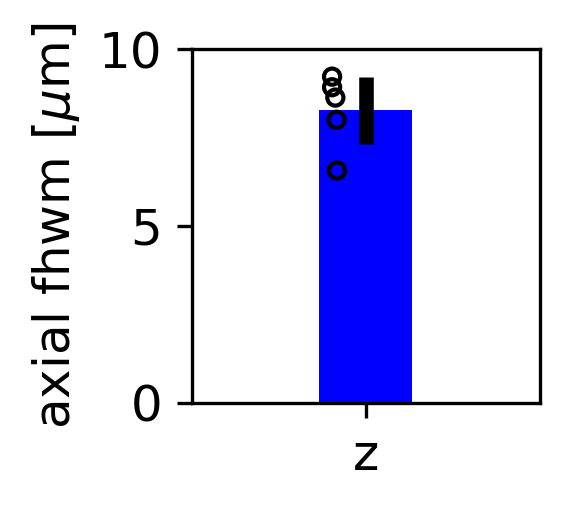

In [125]:
fig, ax = plt.subplots(figsize=(2,1.8), dpi=300)

bar_names = ['x', 'y', 'z']
bar_positions = np.asarray([1, 2, 3])
num_beads = fhwms.shape[0]

plt.bar(bar_positions[2:], np.mean(fhwms[:,2:], axis=0), yerr=np.std(fhwms[:,2:], axis=0),
             width=0.8, color='blue', error_kw={'elinewidth':3.5})
    
for i_bar, bar_name in enumerate(bar_names[2:]):
    ax.scatter([i_bar+3]*num_beads + np.random.random(num_beads) * 0.1 - 0.3, fhwms[:,i_bar+2],
               s=15, c='none', edgecolors='black', alpha=1, zorder=10)
    
ax.set_xticks([3])
ax.set_xticklabels(bar_names[2:], fontsize=12)

ax.set_xlim(1.5,4.5)
ax.set_ylim([0,10])
ax.set_yticks([0,5,10])
ax.set_yticklabels([0,5,10], fontsize=12)

ax.set_ylabel(r'axial fhwm [$\mu$m]', fontsize=12)
plt.tight_layout()
plt.savefig('2023-09-15_BeadBased_PSFmeasuremen_multi_AxialFHWM.pdf')


In [127]:
camera_tiff_folder = r'S:\DBIO_Bianco_Lab6\MATTHIAS\scanimage_computer\240604\HoloScan2'

In [146]:
camera_forward_stack_filename = "SP1_20um-100to100um_cameraZstack_zInFcous"
camera_forward_stack = tifffile.imread(os.path.join(camera_tiff_folder, camera_forward_stack_filename+".tiff"))[::4]

In [142]:
camera_forward_stack[::2].shape

(25, 2048, 1536)

In [147]:
#annotate center of bead-of-interest with one point
camera_forward_stack_viewer = napari.view_image(camera_forward_stack)

In [148]:
(z0, y0, x0) = camera_forward_stack_viewer.layers[1].data[0].astype(int)

x_range = 50
y_range = 50
z_range = 75

xy_maxZ = np.max(camera_forward_stack[z0-z_range:z0+z_range,y0-y_range:y0+y_range,x0-x_range:x0+x_range], axis=0)
xz_maxY = np.max(camera_forward_stack[z0-z_range:z0+z_range,y0-y_range:y0+y_range,x0-x_range:x0+x_range], axis=2)
yz_maxX = np.max(camera_forward_stack[z0-z_range:z0+z_range,y0-y_range:y0+y_range,x0-x_range:x0+x_range], axis=1)

xy_meanZ = np.mean(camera_forward_stack[z0-z_range:z0+z_range,y0-y_range:y0+y_range,x0-x_range:x0+x_range], axis=0)
xz_meanY = np.mean(camera_forward_stack[z0-z_range:z0+z_range,y0-y_range:y0+y_range,x0-x_range:x0+x_range], axis=2)
yz_meanX = np.mean(camera_forward_stack[z0-z_range:z0+z_range,y0-y_range:y0+y_range,x0-x_range:x0+x_range], axis=1)

In [100]:
camera_zoomedIn_forward_stack_viewer = napari.view_image(camera_forward_stack[z0-z_range:z0+z_range,y0-y_range:y0+y_range,x0-x_range:x0+x_range])

## sliding z
bbox_rects = np.array([[0,1,45], [0,1,55], [0,3,55], [0,3,45]])
bbox_Rects = np.asarray(2*z_range*[bbox_rects])

zzz = np.asarray(4*[np.arange(2*z_range)])
bbox_Rects[:,:,0] = zzz.T

text_parameters = {'text': 'label',
    'size': 15,
    'color': 'red',
    'anchor': 'lower_right'}
properties={'label':['z = {} μm'.format(z) for z in np.arange(2*z_range)]}

shapes_layer = zoomedIn_forward_stack_viewer.add_shapes(
    bbox_Rects,
    #ndim=2,
    shape_type='polygon',
    face_color=[0,0,0,0],
    edge_color=[0,0,0,0],
    edge_width=1,
    text=text_parameters,
    properties=properties)

In [185]:
camera_animation = Animation(camera_zoomedIn_forward_stack_viewer)
camera_zoomedIn_forward_stack_viewer.dims.set_point(0,0)
camera_animation.capture_keyframe()
camera_zoomedIn_forward_stack_viewer.dims.set_point(0,z_range*2)
camera_animation.capture_keyframe(steps=z_range*2)
camera_animation.animate('zoomedIn_camera_forward_stack_ROI5.mov', canvas_only=True, fps=25)

Rendering frames...


100%|██████████| 201/201 [00:01<00:00, 149.47it/s]


In [149]:
popt, pcov = fit_gaussian_3d(camera_forward_stack[z0-z_range:z0+z_range,y0-y_range:y0+y_range,x0-x_range:x0+x_range], [1,1,1])

[685.266212, 7.733788, 51.16044220503588, 50.81909563592899, 21.22437594617282, 296.073751956997, 12.035961937410232, -19.871424714512475, 412.14321882110033, -57.23718855494875, 131.4356323188585]


In [109]:
popt

array([ 9.91046546e+02,  4.40117019e+00,  5.07022554e+01,  5.16820738e+01,
        2.52862936e+01,  4.68047113e+01,  6.53808978e-01, -1.10528993e+00,
        8.82445251e+01, -9.43572968e+00,  7.63932083e+00])

In [150]:
height = popt[0]
background = popt[1]
mu_x = popt[2]
mu_y = popt[3]
mu_z = popt[4]
cxx = popt[5]
cxy = popt[6]
cxz = popt[7]
cyy = popt[8]
cyz = popt[9]
czz = popt[10]
cov = np.array([[cxx, cxy, cxz], [cxy, cyy, cyz], [cxz, cyz, czz]])
eigval, eigvec = np.linalg.eig(cov)
pa3, pa2, pa1 = np.sort(np.sqrt(eigval)) / 2
fwhm_x = 2 * np.sqrt(2 * np.log(2)) * np.sqrt(cxx)
fwhm_y = 2 * np.sqrt(2 * np.log(2)) * np.sqrt(cyy)
fwhm_z = 2 * np.sqrt(2 * np.log(2)) * np.sqrt(czz)


In [151]:
camera_px_size_um = 0.5
camera_step_size_um = 4
print([fwhm_x * camera_px_size_um, fwhm_y * camera_px_size_um, fwhm_z * camera_step_size_um])
scalebar_size_um = 10

[8.092949906257587, 11.646569611492499, 34.74719141715938]


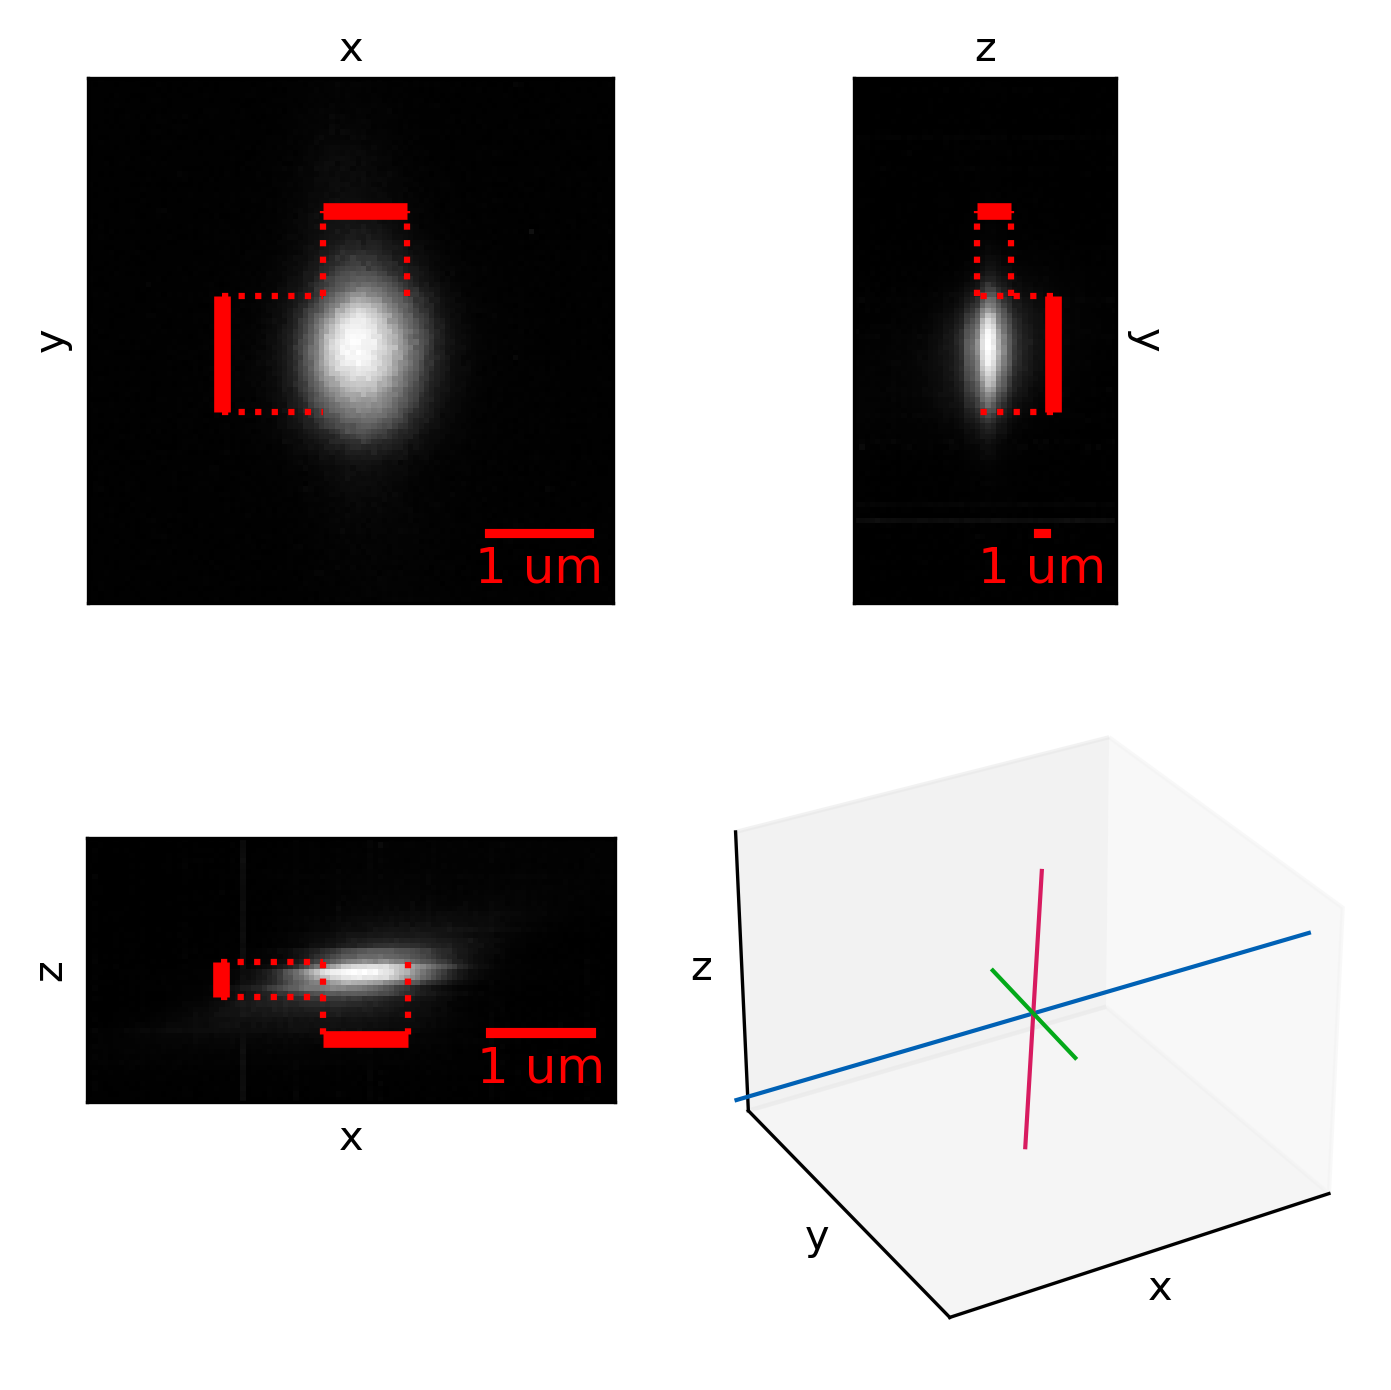

In [107]:
annot_colour = 'red'

xy_spacing = 1
z_spacing = 1

fig, axes = plt.subplots(2,2, figsize=(5,5), dpi=300)
axes[1,1].set_xticks([])
axes[1,1].set_yticks([])

fontprops = fm.FontProperties(size=12)
cmap = 'Greys_r'
(vmin, vmax) = (0,750)

axes[0,0].imshow(xy_maxZ, cmap=cmap)
axes[0,0].set_xlabel('x')    
axes[0,0].xaxis.set_label_position('top') 
axes[0,0].set_ylabel('y')    
axes[0,0].yaxis.set_label_position('left')
axes[0,0].set_xticks([])
axes[0,0].set_yticks([])

scalebar = AnchoredSizeBar(axes[0,0].transData,
                           scalebar_size_um/camera_px_size_um, '10 um', 'lower right',  
                           pad=0.1,
                           color=annot_colour,
                           frameon=False,
                           size_vertical=1,
                           fontproperties=fontprops)
axes[0,0].add_artist(scalebar)

cx = mu_x / xy_spacing + 0.5
cy = mu_y / xy_spacing + 0.5
cz = (mu_z + z_spacing * 0.5) / xy_spacing + 0.5

dx = (fwhm_x / 2) / xy_spacing
dy = (fwhm_y / 2) / xy_spacing
dz = (fwhm_z / 2) / z_spacing

axes[0,0].plot([cx - dx, cx + dx],
               [y_range / 2,]* 2,
    linewidth=4,
    c=annot_colour,
    solid_capstyle="butt",
)
axes[0,0].plot([cx - dx, cx - dx], [cy - dy, y_range / 2], ":", c=annot_colour)
axes[0,0].plot([cx + dx, cx + dx], [cy - dy, y_range / 2], ":", c=annot_colour)

axes[0,0].plot([x_range / 2,]* 2,
        [cy - dy, cy + dy],
        linewidth=4,
        c=annot_colour,
        solid_capstyle="butt",
    )
axes[0,0].plot([x_range / 2, cx - dx], [cy - dy, cy - dy], ":", c=annot_colour)
axes[0,0].plot([x_range / 2, cx - dx], [cy + dy, cy + dy], ":", c=annot_colour)



axes[1,0].imshow(xz_maxY, cmap=cmap)
axes[1,0].set_xlabel('x')    
axes[1,0].xaxis.set_label_position('bottom')
axes[1,0].set_ylabel('z')    
axes[1,0].yaxis.set_label_position('left') 
axes[1,0].set_xticks([])
axes[1,0].set_yticks([])

scalebar = AnchoredSizeBar(axes[1,0].transData,
                           scalebar_size_um/camera_px_size_um, '10 um', 'lower right',  
                           pad=0.1,
                           color=annot_colour,
                           frameon=False,
                           size_vertical=1,
                           fontproperties=fontprops)
axes[1,0].add_artist(scalebar)

axes[1,0].plot([cx - dx, cx + dx],
               [z_range / 2,]* 2,
    linewidth=4,
    c=annot_colour,
    solid_capstyle="butt",
)
axes[1,0].plot([cx - dx, cx - dx], [cz - dz, z_range / 2], ":", c=annot_colour)
axes[1,0].plot([cx + dx, cx + dx], [cz - dz, z_range / 2], ":", c=annot_colour)

axes[1,0].plot([x_range / 2,]* 2,
        [cz - dz, cz + dz],
        linewidth=4,
        c=annot_colour,
        solid_capstyle="butt",
    )
axes[1,0].plot([x_range / 2, cx - dx], [cz - dz, cz - dz], ":", c=annot_colour)
axes[1,0].plot([x_range / 2, cx - dx], [cz + dz, cz + dz], ":", c=annot_colour)



axes[0,1].imshow(yz_maxX.T, cmap=cmap)
axes[0,1].set_xlabel('z')    
axes[0,1].xaxis.set_label_position('top') 
axes[0,1].set_ylabel('y') 
axes[0,1].yaxis.set_label_position('right')
axes[0,1].yaxis.label.set_rotation(-90)
axes[0,1].yaxis.labelpad = 12
axes[0,1].set_xticks([])
axes[0,1].set_yticks([])

scalebar = AnchoredSizeBar(axes[0,1].transData,
                           scalebar_size_um/camera_step_size_um, '10 um', 'lower right',  
                           pad=0.1,
                           color=annot_colour,
                           frameon=False,
                           size_vertical=1,
                           fontproperties=fontprops)
axes[0,1].add_artist(scalebar)

axes[0,1].plot([cz - dz, cz + dz],
               [y_range / 2,]* 2,
    linewidth=4,
    c=annot_colour,
    solid_capstyle="butt",
)
axes[0,1].plot([cz - dz, cz - dz], [cy - dy, y_range / 2], ":", c=annot_colour)
axes[0,1].plot([cz + dz, cz + dz], [cy - dy, y_range / 2], ":", c=annot_colour)

axes[0,1].plot([z_range / 2,]* 2,
        [cy - dy, cy + dy],
        linewidth=4,
        c=annot_colour,
        solid_capstyle="butt",
    )
axes[0,1].plot([z_range / 2, cz - dz], [cy - dy, cy - dy], ":", c=annot_colour)
axes[0,1].plot([z_range / 2, cz - dz], [cy + dy, cy + dy], ":", c=annot_colour)


bbox_size = (pa1 // 200 + 1.5)
axes[1,1] = fig.add_axes(
        [0.525, 0.025, 0.45, 0.45], projection="3d", computed_zorder=False)
axes[1,1].set_xlim(-bbox_size, bbox_size)
axes[1,1].set_ylim(-bbox_size, bbox_size)
axes[1,1].set_zlim(-bbox_size, bbox_size)


# Hide grid lines
axes[1,1].grid(False)

# Hide axes ticks
axes[1,1].set_xticks([])
axes[1,1].set_yticks([])
axes[1,1].set_zticks([])


neg = -eigvec[:, 0] * pa1 / 2.0
pos = eigvec[:, 0] * pa1 / 2.0
axes[1,1].quiver3D(
    0, 0, 0, *neg, linewidth=1, zorder=2, arrow_length_ratio=0, color="#0061B5"
)
axes[1,1].quiver3D(
    0, 0, 0, *pos, linewidth=1, zorder=2, arrow_length_ratio=0, color="#0061B5"
)
neg = -eigvec[:, 1] * pa2 / 2.0
pos = eigvec[:, 1] * pa2 / 2.0
axes[1,1].quiver3D(
    0, 0, 0, *neg, linewidth=1, zorder=2, arrow_length_ratio=0, color="#D81B60"
)
axes[1,1].quiver3D(
    0, 0, 0, *pos, linewidth=1, zorder=2, arrow_length_ratio=0, color="#D81B60"
)
neg = -eigvec[:, 2] * pa3 / 2.0
pos = eigvec[:, 2] * pa3 / 2.0
axes[1,1].quiver3D(
    0, 0, 0, *neg, linewidth=1, zorder=2, arrow_length_ratio=0, color="#03A919"
)
axes[1,1].quiver3D(
    0, 0, 0, *pos, linewidth=1, zorder=2, arrow_length_ratio=0, color="#03A919"
)

axes[1,1].view_init(30, 60)

axes[1,1].set_xlabel('x', labelpad=-15)
axes[1,1].set_ylabel('y', labelpad=-15)
axes[1,1].set_zlabel('z', labelpad=-15)

plt.savefig('2024-05-31_DiskSize.pdf', dpi=300)

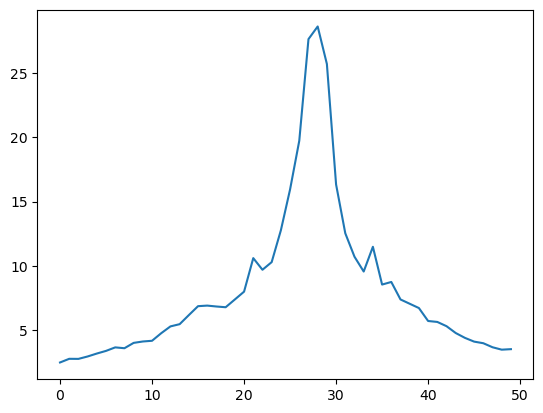

In [180]:
plt.figure()
plt.plot(np.mean(camera_forward_stack[z0-z_range:z0+z_range,y0-y_range:y0+y_range,x0-x_range:x0+x_range], axis=(1,2)))

In [152]:
positions = [
    ['SP1_-20um'],
    ['SP1_-10um'],
    ['SP1_0um'],
    ['SP1_10um'],
    ['SP1_20um']
                    ]

fhwms = np.asarray([
    [7.987978485977822, 11.496885735944335, 33.1595588998249],
    [8.023960031029834, 11.649060192149566, 33.386041467270324],
    [8.055154498256336, 11.060459199621745, 26.03440197324377],
    [8.122227219507103, 11.12310278217952, 28.936436910747926],
    [8.092949906257587, 11.646569611492499, 34.74719141715938]    
                                                                ])

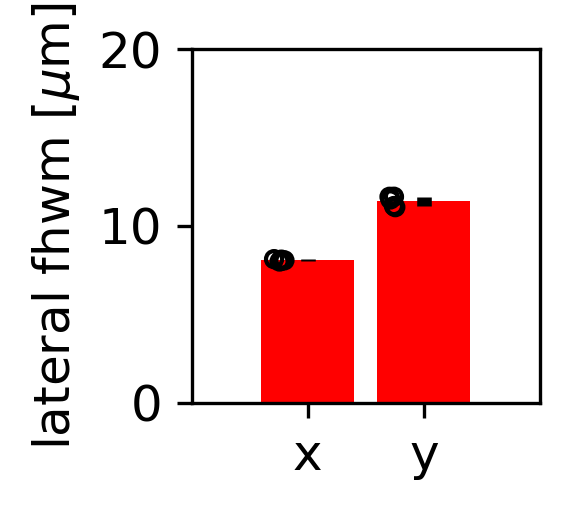

In [154]:
fig, ax = plt.subplots(figsize=(2,1.8), dpi=300)

bar_names = ['x', 'y', 'z']
bar_positions = np.asarray([1, 2, 3])
num_beads = fhwms.shape[0]

plt.bar(bar_positions[:2], np.mean(fhwms[:,:2], axis=0), yerr=np.std(fhwms[:,:2], axis=0),
             width=0.8, color='red', error_kw={'elinewidth':3.5})
    
for i_bar, bar_name in enumerate(bar_names[:2]):
    ax.scatter([i_bar+1]*num_beads + np.random.random(num_beads) * 0.1 - 0.3, fhwms[:,i_bar],
               s=15, c='none', edgecolors='black', alpha=1, zorder=10)
    
ax.set_xticks([1,2])
ax.set_xticklabels(bar_names[:2], fontsize=12)

ax.set_xlim(0,3)
ax.set_ylim([0,20])
ax.set_yticks([0,10,20])
ax.set_yticklabels([0,10,20], fontsize=12)

ax.set_ylabel(r'lateral fhwm [$\mu$m]', fontsize=12)
plt.tight_layout()
plt.savefig('2024-05-31_SubstageBased_DiskMeasurement_multi_LateralFHWM.pdf')


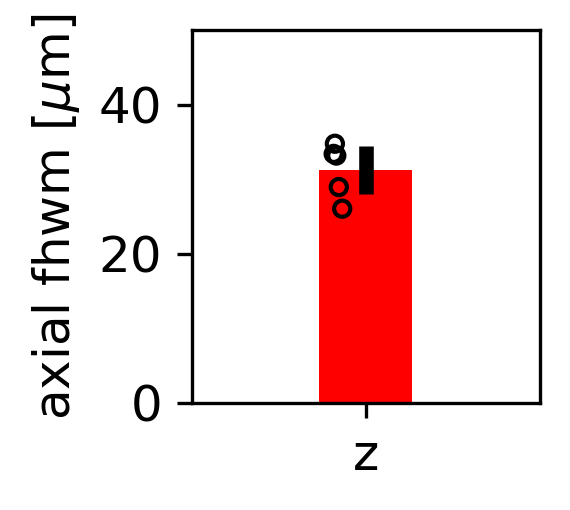

In [156]:
fig, ax = plt.subplots(figsize=(2,1.8), dpi=300)

bar_names = ['x', 'y', 'z']
bar_positions = np.asarray([1, 2, 3])
num_beads = fhwms.shape[0]

plt.bar(bar_positions[2:], np.mean(fhwms[:,2:], axis=0), yerr=np.std(fhwms[:,2:], axis=0),
             width=0.8, color='red', error_kw={'elinewidth':3.5})
    
for i_bar, bar_name in enumerate(bar_names[2:]):
    ax.scatter([i_bar+3]*num_beads + np.random.random(num_beads) * 0.1 - 0.3, fhwms[:,i_bar+2],
               s=15, c='none', edgecolors='black', alpha=1, zorder=10)
    
ax.set_xticks([3])
ax.set_xticklabels(bar_names[2:], fontsize=12)

ax.set_xlim(1.5,4.5)
ax.set_ylim([0,50])
ax.set_yticks([0,20,40])
ax.set_yticklabels([0,20,40], fontsize=12)

ax.set_ylabel(r'axial fhwm [$\mu$m]', fontsize=12)
plt.tight_layout()
plt.savefig('2024-05-31_SubstageBased_DiskMeasurement_multi_AxialFHWM.pdf')
